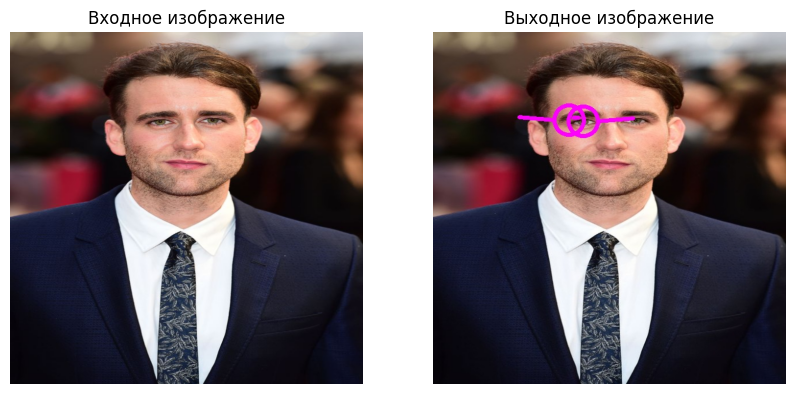

In [30]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt


COLOR_DICT = {
    'red': (0, 0, 255),
    'blue': (255, 0, 0),
    'cian': (255, 255, 0),  
    'magenta': (255, 0, 255),
    'yellow': (0, 255, 255),
}

def load_image_data(file_path):
   
    return pd.read_excel(file_path)


def parse_image_size(size_str):

    if pd.isna(size_str):
        return None, None
    try:
        width_str, height_str = size_str.lower().split('x')  
        return int(width_str), int(height_str)
    except ValueError:
        return None, None


def get_glasses_color(color_name):
    return COLOR_DICT.get(color_name.lower(), COLOR_DICT['yellow'])


def add_glasses_to_face(image_path, output_path, line_width, temple_length=60, resize_dims=None, glasses_color=(0, 255, 255)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Ошибка: Изображение '{image_path}' не найдено.")
        return

    if resize_dims:
        image = cv2.resize(image, resize_dims)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        cv2.imwrite(output_path, image)
        return

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=3, minSize=(10, 10))
        if len(eyes) < 2:
            eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.05, minNeighbors=3, minSize=(5, 5))
            if len(eyes) < 2:
                continue

        eyes = sorted(eyes, key=lambda ex: ex[0])[:2]

        if len(eyes) < 2:
            continue

        (ex1, ey1, ew1, eh1), (ex2, ey2, ew2, eh2) = eyes
        eye1_center = (x + ex1 + ew1 // 2, y + ey1 + eh1 // 2)
        eye2_center = (x + ex2 + ew2 // 2, y + ey2 + eh2 // 2)
        radius = int(0.5 * (ew1 + ew2) / 2)


        eye1_center = (eye1_center[0] - int(0.1 * radius), eye1_center[1])
        eye2_center = (eye2_center[0] + int(0.1 * radius), eye2_center[1])

    
        cv2.circle(image, eye1_center, radius, glasses_color, line_width)
        cv2.circle(image, eye2_center, radius, glasses_color, line_width)

        bridge_y = int((eye1_center[1] + eye2_center[1]) / 2 - 0.2 * radius)
        cv2.line(image, (eye1_center[0] + int(0.7 * radius), bridge_y),
                 (eye2_center[0] - int(0.7 * radius), bridge_y), glasses_color, line_width)

        cv2.line(image, (eye1_center[0] - radius, eye1_center[1]),
                 (eye1_center[0] - radius - temple_length, eye1_center[1] - int(0.2 * radius)), glasses_color, line_width)
        cv2.line(image, (eye2_center[0] + radius, eye2_center[1]),
                 (eye2_center[0] + radius + temple_length, eye2_center[1] - int(0.2 * radius)), glasses_color, line_width)
        break

    cv2.imwrite(output_path, image)


def display_images(input_path, output_path, resize_dims=None):
    input_image = cv2.imread(input_path)
    if input_image is None:
        print(f"Ошибка: Входное изображение '{input_path}' не найдено.")
        return

    if resize_dims:
        input_image = cv2.resize(input_image, resize_dims)

    output_image = cv2.imread(output_path)
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image_rgb)
    plt.title("Входное изображение")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image_rgb)
    plt.title("Выходное изображение")
    plt.axis("off")

    plt.show()




df = load_image_data('DataSet/kr1.xlsx')
row_data = df.iloc[3]

input_image_name = row_data['file name']
line_width = int(row_data['line width'])
image_width, image_height = parse_image_size(row_data.get('image size'))
glasses_color = get_glasses_color(row_data.get('glasses color', 'yellow'))

input_image_path = f"DataSet/Images/{input_image_name}"
output_image_path = f"output_{input_image_name}"
resize_dims = (image_width, image_height) if image_width and image_height else None

add_glasses_to_face(input_image_path, output_image_path, line_width, resize_dims=resize_dims, glasses_color=glasses_color)

display_images(input_image_path, output_image_path, resize_dims)
